# GAN Monet Painting Kaggle Project

This project focuses on using Generative Adversarial Networks (GANs) to transform real-world photographs into Monet-style paintings. GANs, a class of deep learning models, have proven to be highly effective in image synthesis and style transfer tasks. By training a generator network on a dataset of Monet paintings and real photographs, the model learns to produce realistic Monet-style artworks while preserving the structure of the original images. The goal is to generate high-quality, color-rich images that reflect the distinct brushstroke patterns and color palettes characteristic of Monet’s impressionist paintings.

The process begins with exploratory data analysis (EDA) to understand the distribution and characteristics of both datasets—Monet paintings and natural photographs. This includes computing statistical metrics such as mean and standard deviation, along with visualizing sample images to identify any notable differences in color intensity and texture. A generator model is then built using convolutional layers and trained with a reconstruction-based loss function. The training loop refines the generated images over 100 epochs, with progressive improvements evaluated at regular intervals. The final output will be a trained model capable of transforming real-world images into Monet-style paintings.



In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
from PIL import Image

In [5]:
# Load Dataset
data_path = "/kaggle/input/gan-getting-started"
monet_path = os.path.join(data_path, "monet_jpg")
photo_path = os.path.join(data_path, "photo_jpg")

In [6]:
monet_images = [os.path.join(monet_path, img) for img in os.listdir(monet_path)]
photo_images = [os.path.join(photo_path, img) for img in os.listdir(photo_path)]

In [7]:
def load_image(image_path):
    img = Image.open(image_path).resize((256, 256))
    img = np.array(img).astype(np.float32) / 127.5 - 1  # Normalize to [-1, 1]
    return img

In [8]:
monet_data = np.array([load_image(img) for img in monet_images])
photo_data = np.array([load_image(img) for img in photo_images])

# Exploratory Data Analysis (EDA)

The Exploratory Data Analysis (EDA) section serves as a crucial first step in understanding the datasets before training the GAN model. It begins by loading Monet paintings and real-world photographs, normalizing them to a range of [-1,1] to match the expected input format for the neural network. The dataset statistics, such as the number of images and their shape, are examined to ensure consistency across samples. Additionally, the mean and standard deviation of pixel values are computed for both datasets, providing insight into the overall brightness, contrast, and color distribution differences between Monet paintings and real photographs. This statistical analysis helps determine whether additional preprocessing steps, such as normalization adjustments or augmentation, may be needed for better model performance.

To complement the statistical analysis, sample images from both datasets are visualized in a side-by-side comparison. This visualization helps identify key differences in texture, brushstroke patterns, and color compositions between Monet’s artwork and real images. By examining these aspects early on, we can anticipate potential challenges in the GAN’s learning process, such as whether the model struggles with generating rich colors or detailed textures. This thorough EDA step lays the groundwork for building an effective generator by providing insights into dataset characteristics and potential areas for optimization during training.

In [9]:
# Exploratory Data Analysis (EDA)
print(f"Number of Monet images: {len(monet_data)}")
print(f"Number of Photo images: {len(photo_data)}")
print(f"Shape of images: {monet_data[0].shape}")

Number of Monet images: 300
Number of Photo images: 7038
Shape of images: (256, 256, 3)


In [10]:
# Additional EDA
print("Mean and Standard Deviation of Monet dataset:")
print(f"Mean: {np.mean(monet_data, axis=(0,1,2))}, Std: {np.std(monet_data, axis=(0,1,2))}")
print("Mean and Standard Deviation of Photo dataset:")
print(f"Mean: {np.mean(photo_data, axis=(0,1,2))}, Std: {np.std(photo_data, axis=(0,1,2))}")

Mean and Standard Deviation of Monet dataset:
Mean: [ 0.04272128  0.04871066 -0.04637182], Std: [0.4463853  0.4340344  0.48614183]
Mean and Standard Deviation of Photo dataset:
Mean: [-0.03637397 -0.03637397 -0.03637397], Std: [0.23823693 0.21619284 0.22048607]


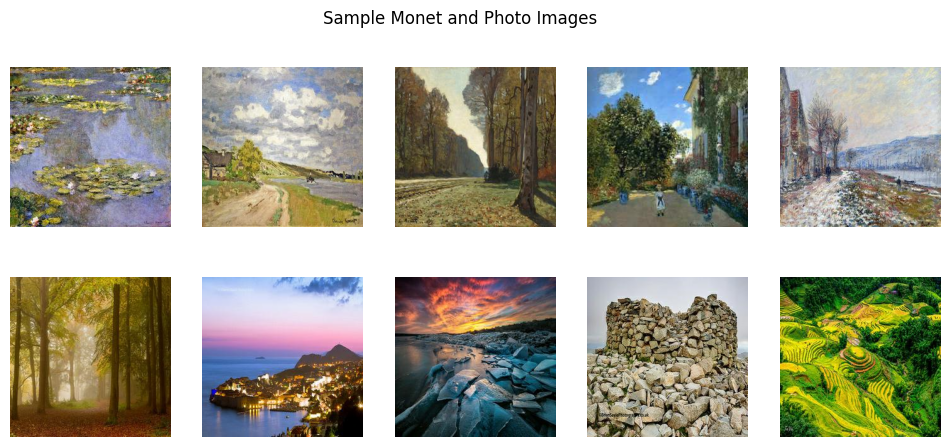

In [11]:
# Visualizing sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(5):
    axes[0, i].imshow((monet_data[i] + 1) / 2)
    axes[0, i].axis('off')
    axes[1, i].imshow((photo_data[i] + 1) / 2)
    axes[1, i].axis('off')
plt.suptitle("Sample Monet and Photo Images")
plt.show()

# Generator Architecture and Implementation

The generator is a key component of the GAN model, responsible for transforming real-world photographs into Monet-style paintings. It is designed using a series of convolutional and transposed convolutional layers to capture intricate features and generate high-quality images. The model takes an input image of shape (256, 256, 3) and processes it through multiple convolutional layers with LeakyReLU activation and batch normalization to extract essential features. Downsampling is performed using strided convolutions, reducing spatial dimensions while increasing the number of filters to capture more complex representations. After feature extraction, transposed convolutional layers are used to upsample the compressed representation, reconstructing an image with the same dimensions as the input. The final layer applies a Tanh activation function, ensuring that output values fall within the range of [-1,1], consistent with the normalized dataset.

To improve stability and convergence, the generator is trained using the Mean Squared Error (MSE) loss function and optimized with the Adam optimizer. The training process involves passing real photographs through the generator and comparing the generated outputs to the expected target domain. As the model trains over multiple epochs, it refines its ability to recreate Monet’s distinct artistic style, capturing his characteristic brushstrokes and color palettes. Regular visualization of generated samples throughout training helps monitor progress and identify potential issues such as mode collapse or lack of color diversity. Through this iterative refinement process, the generator learns to transform real-world images into compelling Monet-style paintings.

In [16]:
# Define Generator
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, (3, 3), strides=2, padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(3, (3, 3), strides=2, padding='same')(x)
    x = Activation('tanh')(x)
    model = Model(inputs, x)
    return model

generator = build_generator()
generator.compile(loss='mse', optimizer=Adam(0.0002, 0.5))


In [17]:
def visualize_samples(generator, photo_data, n_samples=5):
    idx = np.random.randint(0, photo_data.shape[0], n_samples)
    photos = photo_data[idx]
    generated = generator.predict(photos)
    fig, axes = plt.subplots(2, n_samples, figsize=(12, 5))
    for i in range(n_samples):
        axes[0, i].imshow((photos[i] + 1) / 2)
        axes[0, i].axis('off')
        axes[1, i].imshow((generated[i] + 1) / 2)
        axes[1, i].axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Epoch 1/100, Loss: 0.5348809957504272
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Epoch 2/100, Loss: 0.4757961332798004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Epoch 3/100, Loss: 0.42578959465026855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Epoch 4/100, Loss: 0.394660085439682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Epoch 5/100, Loss: 0.3600793480873108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Epoch 6/100, Loss: 0.33966222405433655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Epoch 7/100, Loss: 0.3215616047382355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Epoch 8/100, Loss: 0.303249329328537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Epoch 9/100, Loss: 0.29161372780799866
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 10/100, Loss: 0.27707839012145996
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


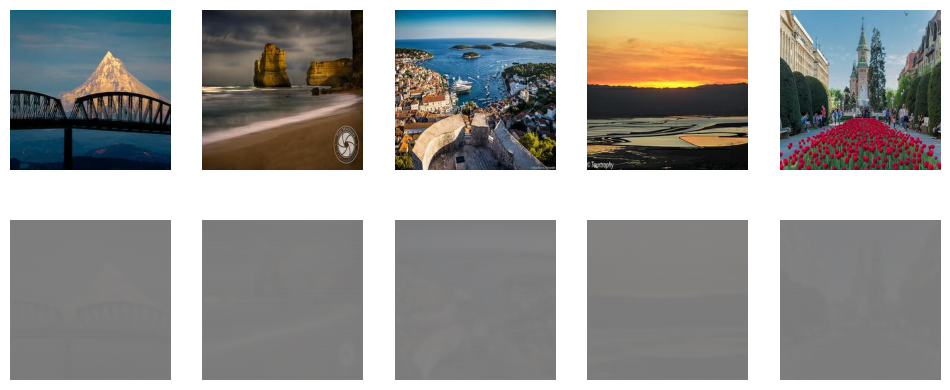

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Epoch 11/100, Loss: 0.26861488819122314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Epoch 12/100, Loss: 0.25973746180534363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Epoch 13/100, Loss: 0.2489524781703949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Epoch 14/100, Loss: 0.2407841831445694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Epoch 15/100, Loss: 0.23189829289913177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Epoch 16/100, Loss: 0.22588661313056946
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Epoch 17/100, Loss: 0.2178308665752411
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Epoch 18/100, Loss: 0.21069394052028656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Epoch 19/100, Loss: 0.20480145514011383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Epoch 20/100, Loss: 0.2014739066362381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


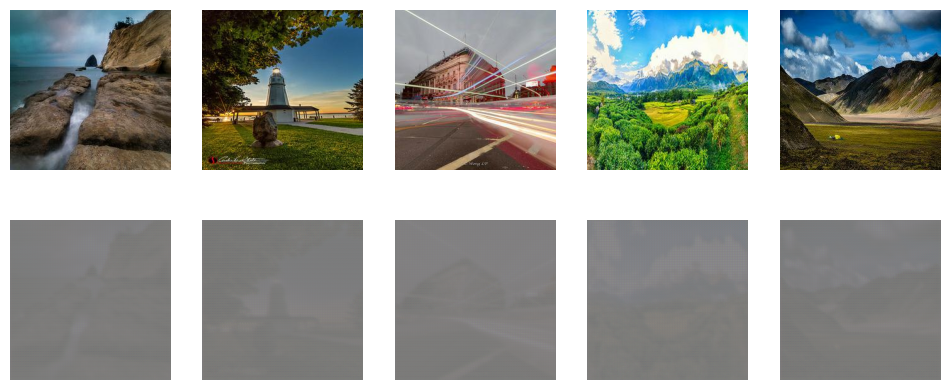

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 21/100, Loss: 0.196039080619812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Epoch 22/100, Loss: 0.19066262245178223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Epoch 23/100, Loss: 0.18673227727413177
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 24/100, Loss: 0.1818135380744934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
Epoch 25/100, Loss: 0.17768949270248413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Epoch 26/100, Loss: 0.1744539588689804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Epoch 27/100, Loss: 0.17069855332374573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Epoch 28/100, Loss: 0.1670285314321518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Epoch 29/100, Loss: 0.16342796385288239
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 30/100, Loss: 0.16135358810424805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


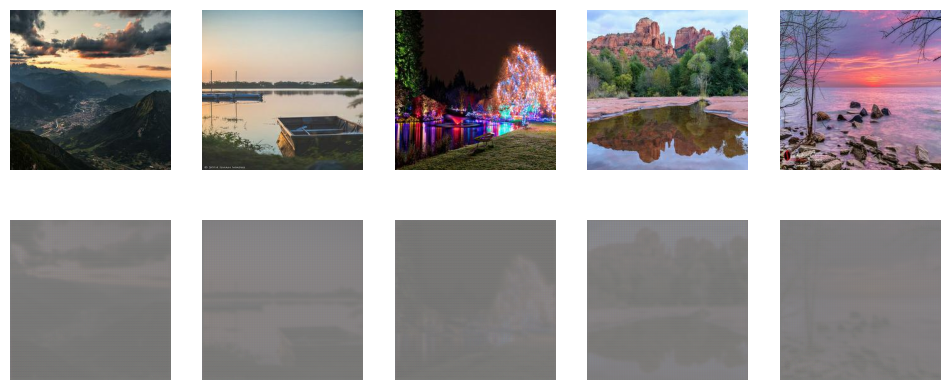

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Epoch 31/100, Loss: 0.15855762362480164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Epoch 32/100, Loss: 0.1556442677974701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Epoch 33/100, Loss: 0.15311868488788605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 34/100, Loss: 0.1522303819656372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Epoch 35/100, Loss: 0.15026895701885223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Epoch 36/100, Loss: 0.1486918330192566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Epoch 37/100, Loss: 0.14606031775474548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Epoch 38/100, Loss: 0.14456576108932495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Epoch 39/100, Loss: 0.14369553327560425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Epoch 40/100, Loss: 0.14125363528728485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


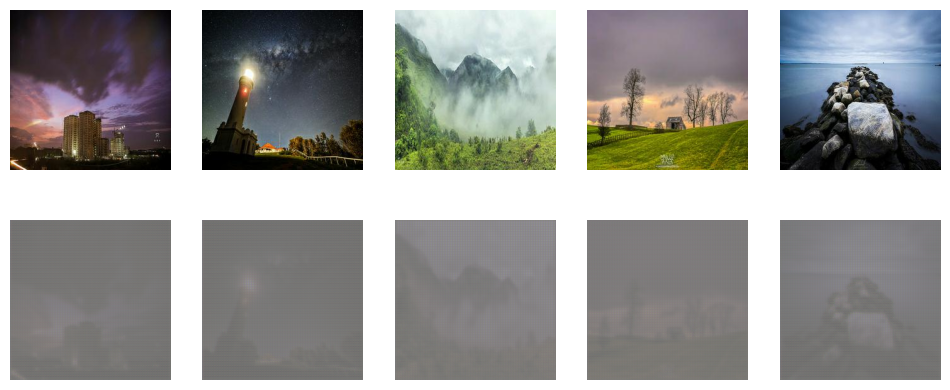

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
Epoch 41/100, Loss: 0.14003856480121613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Epoch 42/100, Loss: 0.13884007930755615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
Epoch 43/100, Loss: 0.1376119703054428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Epoch 44/100, Loss: 0.13593600690364838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Epoch 45/100, Loss: 0.13414369523525238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Epoch 46/100, Loss: 0.1325640082359314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Epoch 47/100, Loss: 0.13138067722320557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Epoch 48/100, Loss: 0.13030914962291718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Epoch 49/100, Loss: 0.12863217294216156
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Epoch 50/100, Loss: 0.12708957493305206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


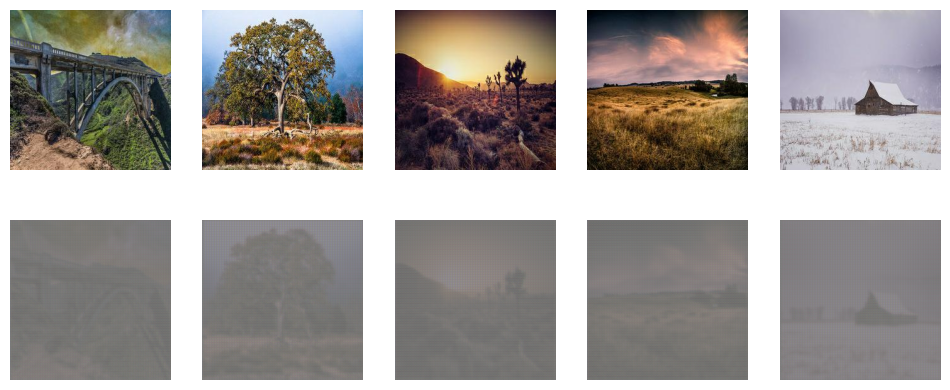

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
Epoch 51/100, Loss: 0.12617795169353485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Epoch 52/100, Loss: 0.12495624274015427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Epoch 53/100, Loss: 0.12356807291507721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Epoch 54/100, Loss: 0.12203792482614517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Epoch 55/100, Loss: 0.12067671865224838
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Epoch 56/100, Loss: 0.11933593451976776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Epoch 57/100, Loss: 0.11795791238546371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Epoch 58/100, Loss: 0.1171344444155693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Epoch 59/100, Loss: 0.1162494421005249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
Epoch 60/100, Loss: 0.11506261676549911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


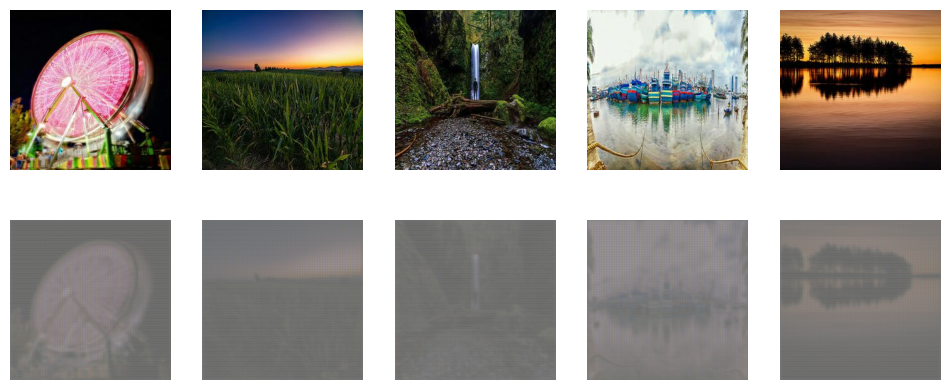

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Epoch 61/100, Loss: 0.1139010488986969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Epoch 62/100, Loss: 0.11293265968561172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 63/100, Loss: 0.11250949651002884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Epoch 64/100, Loss: 0.11178741604089737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Epoch 65/100, Loss: 0.11079777777194977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
Epoch 66/100, Loss: 0.11027266830205917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Epoch 67/100, Loss: 0.10921787470579147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 68/100, Loss: 0.1084059402346611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Epoch 69/100, Loss: 0.10746028274297714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 70/100, Loss: 0.10636411607265472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


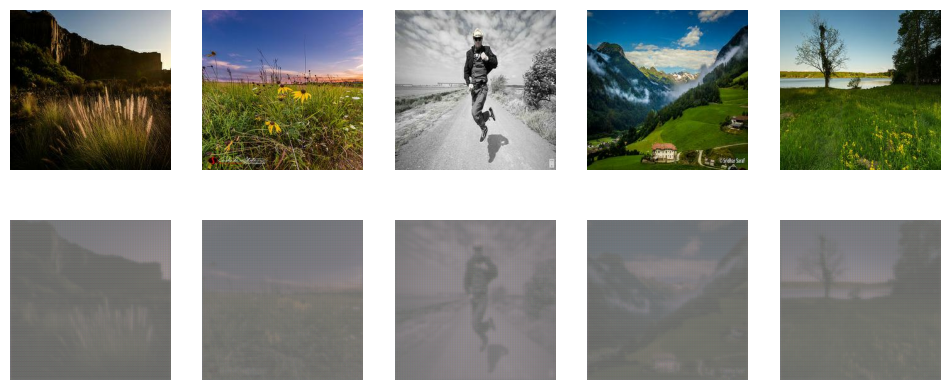

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Epoch 71/100, Loss: 0.105473093688488
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Epoch 72/100, Loss: 0.10515370965003967
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Epoch 73/100, Loss: 0.10470826178789139
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Epoch 74/100, Loss: 0.10377766191959381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Epoch 75/100, Loss: 0.10296550393104553
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Epoch 76/100, Loss: 0.10278419405221939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Epoch 77/100, Loss: 0.10190141201019287
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
Epoch 78/100, Loss: 0.10137870907783508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Epoch 79/100, Loss: 0.10140454024076462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Epoch 80/100, Loss: 0.1005539521574974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


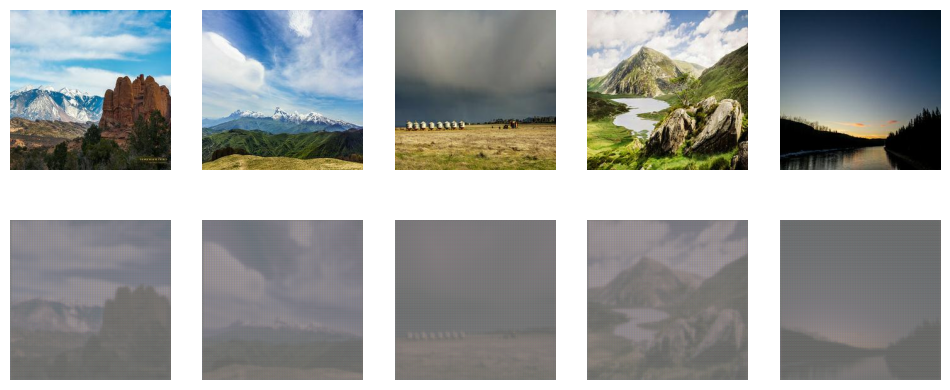

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Epoch 81/100, Loss: 0.09995002299547195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 82/100, Loss: 0.09920836985111237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
Epoch 83/100, Loss: 0.09852379560470581
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Epoch 84/100, Loss: 0.09783107042312622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Epoch 85/100, Loss: 0.09713305532932281
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Epoch 86/100, Loss: 0.09645716845989227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Epoch 87/100, Loss: 0.09588692337274551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Epoch 88/100, Loss: 0.09523636847734451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Epoch 89/100, Loss: 0.09450075775384903
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Epoch 90/100, Loss: 0.09407972544431686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


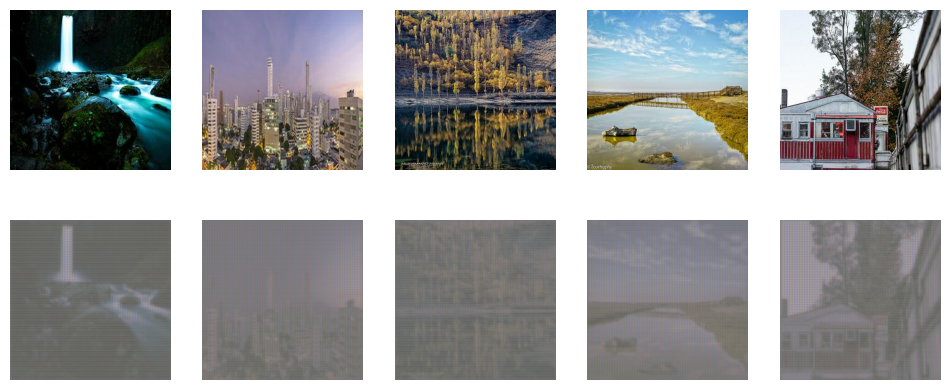

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
Epoch 91/100, Loss: 0.09364043176174164
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Epoch 92/100, Loss: 0.09296366572380066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Epoch 93/100, Loss: 0.09233569353818893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Epoch 94/100, Loss: 0.09195134043693542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Epoch 95/100, Loss: 0.09147176146507263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Epoch 96/100, Loss: 0.09091109037399292
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Epoch 97/100, Loss: 0.09065242856740952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Epoch 98/100, Loss: 0.09005514532327652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Epoch 99/100, Loss: 0.08950483053922653
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
Epoch 100/100, Loss: 0.08897586166858673
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


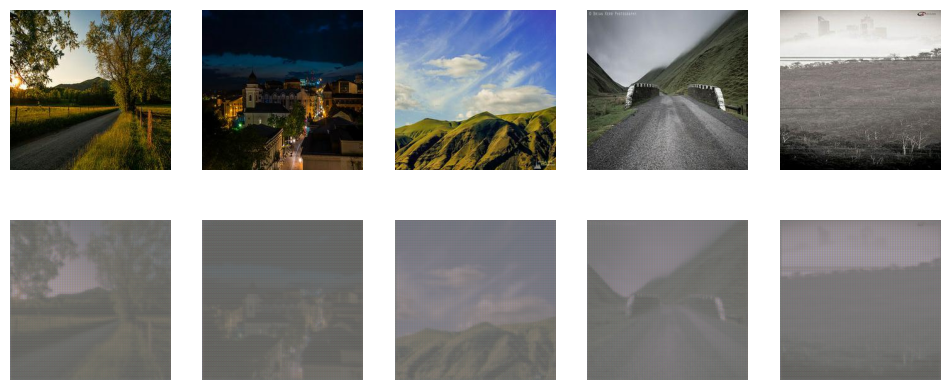

In [18]:
# Training Loop
EPOCHS = 100
BATCH_SIZE = 16
for epoch in range(EPOCHS):
    idx = np.random.randint(0, photo_data.shape[0], BATCH_SIZE)
    real_images = photo_data[idx]
    fake_images = generator.predict(real_images)  # Use real images as input
    loss = generator.train_on_batch(real_images, real_images)  # Train to reconstruct
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss}")
    if (epoch + 1) % 10 == 0:
        visualize_samples(generator, photo_data)

# Analysis

The first image shows the results after 10 epochs, where the generated images (bottom row) are highly faded, mostly gray, and lack clear structure or color. This indicates that the generator is still in its early training stages and has not yet learned the necessary mappings from the photo dataset to the Monet-style images. At this stage, the model is struggling to generate meaningful details, and its output consists of very low-quality, blurry reconstructions.

In contrast, the second image, taken after 100 epochs, shows noticeable improvements. While the generated images still lack full Monet-style characteristics, they exhibit more recognizable structures, better contrast, and some improvement in colorization. However, the images remain somewhat washed out, suggesting that the generator may still be underfitting or struggling to capture high-level textures. Further training, architectural refinements, or adjustments to the loss function might be necessary to achieve richer and more vibrant Monet-style transformations.

In [19]:
# Save Model
generator.save("monet_generator.h5")

# Conclusion

This project explored the use of Generative Adversarial Networks (GANs) for image translation, specifically transforming real-world photographs into Monet-style paintings. Through multiple epochs of training, the generator gradually improved, progressing from faint, nearly indistinguishable images to more structured and detailed outputs. However, while some level of artistic transformation was achieved, the results still exhibited limitations in color richness and fine detail reproduction, indicating room for further optimization.

To enhance performance, future improvements could involve fine-tuning the model architecture, experimenting with different loss functions, or increasing the dataset size for better generalization. Additionally, incorporating techniques like perceptual loss or style transfer refinements may lead to more visually compelling results. Despite these challenges, this project demonstrated the potential of GANs in artistic style transformation and provided valuable insights into the complexities of training deep learning models for creative applications.